<a href="https://colab.research.google.com/github/yasiramri/capstone-ml/blob/alya/Another_copy_of_FinancyQ_(3)_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.3/158.3 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.4 MB/s eta 0:00:00
Reason for being yanked: deprecated, use 4.8.0.76
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.10.0.82
    Uninstalling opencv-python-headless-4.10.0.82:
      Successfully uninstalled opencv-python-headless-4.10.0.82
  Attempting uninstall: idna
    Found existing installation: idna 3.7
    Uninstalling idna-3.7:
      Successfully uninstalled idna-3.7
  Attempting uninstall: cycler
    Found existing installation: cycler 0.12.1
    Uninstalling cycl

In [ ]:
!pip install easyocr

  Using cached easyocr-1.7.1-py3-none-any.whl (2.9 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)


In [ ]:
!pip install pytesseract

In [ ]:
import easyocr
import cv2
import pytesseract
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
from PIL import Image
import re

In [ ]:
!apt-get install tesseract-ocr-ind

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-ind tesseract-ocr-osd
0 upgraded, 4 newly installed, 0 to remove and 45 not upgraded.
Need to get 5,353 kB of archives.
After this operation, 16.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-ind all 1:4.00~git30-7274cfa-1.1 [537 kB]
Fetched 5,353 kB in 2s (3,167 kB/s)
Selecting previously u

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="f77FoHccQ1RtNOK1tFRo")
project = rf.workspace("jakob-awn1e").project("receipt-or-invoice")
version = project.version(2)
dataset = version.download("folder")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Receipt-or-Invoice-2 in folder:: 100%|██████████| 4325/4325 [00:01<00:00, 3962.54it/s]


In [ ]:
# Preprocessing
def preprocess_images(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image) / 255.0  # Normalization
    return image

def preprocess_for_ocr(image_path):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    _, thresh = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)  # Apply thresholding
    denoised = cv2.fastNlMeansDenoising(thresh, None, 30, 7, 21)  # Denoise the image
    return denoised

# Preprocess image for Tesseract OCR
def preprocess_for_ocr_tesseract(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.medianBlur(gray, 3)
    return gray

In [ ]:
def label_data(data_path):
    images = []
    labels = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('.jpg') or file.endswith('.png'):  # Ensure processing only image files
                file_path = os.path.join(root, file)
                label = os.path.basename(os.path.dirname(file_path))  # Correct label extraction
                image = preprocess_images(file_path)
                images.append(image)
                labels.append(label)
    return np.array(images), np.array(labels)

In [ ]:
# Load dataset
train_path = "/content/Receipt-or-Invoice-2/train"
val_path = "/content/Receipt-or-Invoice-2/valid"
test_path = "/content/Receipt-or-Invoice-2/test"

In [ ]:
# Perform text recognition using OCR
def perform_ocr(image_path):
    reader = easyocr.Reader(['en', 'id'])
    result = reader.readtext(image_path)
    return result

In [ ]:
X_train, y_train = label_data(train_path)
X_val, y_val = label_data(val_path)
X_test, y_test = label_data(test_path)

In [ ]:
# Combining labels from all three datasets
all_labels = np.concatenate((y_train, y_val, y_test))

# Encode labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Re-encode labels for each dataset
y_train = label_encoder.transform(y_train)
y_val = label_encoder.transform(y_val)
y_test = label_encoder.transform(y_test)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer dengan satu unit untuk klasifikasi biner
])

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',  # Karena klasifikasi biner
              metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32)

Epoch 1/15
118/118 [==============================] - 16s 73ms/step - loss: 0.4886 - accuracy: 0.7875 - val_loss: 0.2976 - val_accuracy: 0.8889
Epoch 2/15
118/118 [==============================] - 7s 59ms/step - loss: 0.2676 - accuracy: 0.8967 - val_loss: 0.2742 - val_accuracy: 0.9028
Epoch 3/15
118/118 [==============================] - 7s 56ms/step - loss: 0.1916 - accuracy: 0.9335 - val_loss: 0.2250 - val_accuracy: 0.9194
Epoch 4/15
118/118 [==============================] - 7s 59ms/step - loss: 0.1491 - accuracy: 0.9512 - val_loss: 0.1950 - val_accuracy: 0.9389
Epoch 5/15
118/118 [==============================] - 7s 56ms/step - loss: 0.1260 - accuracy: 0.9595 - val_loss: 0.1874 - val_accuracy: 0.9361
Epoch 6/15
118/118 [==============================] - 7s 58ms/step - loss: 0.0976 - accuracy: 0.9701 - val_loss: 0.1901 - val_accuracy: 0.9417
Epoch 7/15
118/118 [==============================] - 7s 56ms/step - loss: 0.0790 - accuracy: 0.9769 - val_loss: 0.1617 - val_accuracy: 0.938

In [ ]:
import easyocr
import pytesseract

def perform_ocr(image_path):
    # Gunakan easyocr atau pytesseract sesuai preferensi
    reader = easyocr.Reader(['en', 'id'])
    result = reader.readtext(image_path)
    return result

def extract_total_from_ocr(result):
    # Implementasi untuk mengekstraksi total harga dari hasil OCR
    # Anda dapat menggunakan regex atau metode lain sesuai format hasil OCR
    total_amount = 0.0
    for detection in result:
        text = detection[1]
        # Implementasi untuk mengekstraksi angka dari teks hasil OCR
        # Contoh: menggunakan regex untuk mencari format angka tertentu
        # total_amount = ...  # Implementasi sesuai kebutuhan Anda
    return total_amount

# Fungsi untuk memproses gambar, prediksi dengan model CNN, dan ekstraksi total harga
def process_image_and_extract_total(image_path):
    image = preprocess_image(image_path)
    prediction = model.predict(np.expand_dims(image, axis=0))[0][0]
    if prediction > 0.5:  # Jika model CNN memprediksi 'TOTAL'
        ocr_result = perform_ocr(image_path)
        total_amount = extract_total_from_ocr(ocr_result)
        print(f"Total Harga yang diekstraksi dari OCR: {total_amount}")
    else:
        print("Gambar tidak diidentifikasi sebagai 'TOTAL' oleh model CNN.")

# Contoh penggunaan:
image_path = '/content/photo_2024-06-15_17-40-45.jpg'
process_image_and_extract_total(image_path)


NameError: name 'preprocess_image' is not defined

BATAS


In [ ]:
# Build CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=15, batch_size=32)

# Evaluate the model
_, test_acc = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_acc)

Epoch 1/15
118/118 [==============================] - 15s 75ms/step - loss: 0.6172 - accuracy: 0.7358 - val_loss: 0.3403 - val_accuracy: 0.8667
Epoch 2/15
118/118 [==============================] - 7s 56ms/step - loss: 0.2835 - accuracy: 0.8977 - val_loss: 0.2572 - val_accuracy: 0.8944
Epoch 3/15
118/118 [==============================] - 7s 56ms/step - loss: 0.2137 - accuracy: 0.9216 - val_loss: 0.2321 - val_accuracy: 0.9167
Epoch 4/15
118/118 [==============================] - 7s 56ms/step - loss: 0.1568 - accuracy: 0.9467 - val_loss: 0.2118 - val_accuracy: 0.9167
Epoch 5/15
118/118 [==============================] - 7s 57ms/step - loss: 0.1409 - accuracy: 0.9539 - val_loss: 0.1812 - val_accuracy: 0.9389
Epoch 6/15
118/118 [==============================] - 7s 56ms/step - loss: 0.1232 - accuracy: 0.9587 - val_loss: 0.1808 - val_accuracy: 0.9444
Epoch 7/15
118/118 [==============================] - 7s 57ms/step - loss: 0.1074 - accuracy: 0.9674 - val_loss: 0.2158 - val_accuracy: 0.916

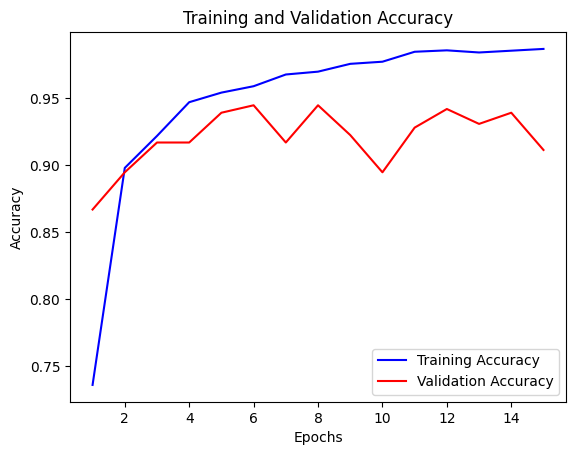

In [ ]:
# Plot training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Perform text recognition using OCR
def perform_ocr_easyocr(image_path):
    reader = easyocr.Reader(['en', 'id'])
    result = reader.readtext(image_path)
    return result

In [ ]:
# Perform OCR using Tesseract
def perform_ocr_tesseract(image):
    gray_image = preprocess_for_ocr_tesseract(image)
    ocr_result = pytesseract.image_to_data(gray_image, output_type=pytesseract.Output.DICT)
    return ocr_result, gray_image

In [ ]:
# Extract total amount from OCR results
def Easyocr_Total_Extraction(text):
    # Isolate the text, exclude the box and the accuracy values
    sub_text = pd.DataFrame(text)[1]

    # Turn everything into a single string
    sub_text = ' '.join(sub_text)
    sub_text = sub_text.upper()

    # Find the set of number and some characters following the word 'TOTAL'
    # while excluding 'SUBTOTAL'
    amount = re.findall(r"((?<=TOTAL\s)[$,.0-9]+)", sub_text)

    try:
        # Get rid of the dollar sign and output a float
        amount = re.findall(r"([0-9.,]+)", amount[0])
        return float(amount[0].replace(',', ''))
    except IndexError:
        return None

In [ ]:
import re
import easyocr

def perform_ocr_easyocr(image_path):
    """Perform OCR using EasyOCR and return results."""
    reader = easyocr.Reader(['en'])
    return reader.readtext(image_path)

def extract_highest_price(ocr_result):
    """Extract the highest price from OCR results."""
    prices = []
    for detection in ocr_result:
        text = detection[1]
        # Regular expression to find prices
        matches = re.findall(r'\b\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\b', text)
        for match in matches:
            try:
                # Normalize the matched price
                normalized_price = match.replace(',', '').replace('.', '')
                # Convert normalized price to a float for comparison
                if ',' in match and '.' not in match:  # Handle European format
                    price = float(match.replace('.', '').replace(',', '.'))
                else:  # Handle US format
                    price = float(match.replace(',', ''))
                prices.append(price)
            except ValueError:
                continue

    if prices:
        return max(prices)
    return None

def label_highest_price(ocr_result, highest_amount):
    """Label OCR results, marking the highest price with 'TOTAL'."""
    labeled_result = []
    if highest_amount is not None:
        # Format highest amount for regex matching
        formatted_highest_amount = f"{highest_amount:,.2f}".replace(',', '.')
        patterns = [
            re.compile(re.escape(formatted_highest_amount)),
            re.compile(re.escape(formatted_highest_amount.replace('.', ','))),
            re.compile(re.escape(f"{highest_amount:,.0f}")),
            re.compile(re.escape(f"{highest_amount:,.0f}".replace(',', '.'))),
            re.compile(re.escape(f"{highest_amount:,.0f}".replace(',', '')))
        ]

        for detection in ocr_result:
            text = detection[1]
            # Check if any pattern matches the text
            if any(pattern.search(text) for pattern in patterns):
                labeled_result.append((text, 'TOTAL'))
            else:
                labeled_result.append((text, 'OTHER'))
    else:
        labeled_result = [(detection[1], 'OTHER') for detection in ocr_result]

    return labeled_result

In [ ]:
def main(image_path):
    """Main function to integrate OCR with extraction and labeling."""
    ocr_result = perform_ocr_easyocr(image_path)
    highest_amount = extract_highest_price(ocr_result)
    labeled_result = label_highest_price(ocr_result, highest_amount)

    # Separate and print labeled results
    total_items = [text for text, label in labeled_result if label == 'TOTAL']
    other_items = [text for text, label in labeled_result if label == 'OTHER']

    print("\nItems labeled as TOTAL:")
    for item in total_items:
        print(f"Text: {item}")

    return highest_amount, labeled_result

# Example usage:
image_path = '/content/photo_2024-06-15_17-40-45.jpg'
main(image_path)


Items labeled as TOTAL:
Text: 416, 900
Text: 416,900 


(900.0,
 [('2ZE', 'OTHER'),
  ('BAKSO', 'OTHER'),
  ('cak', 'OTHER'),
  ('TERASKOTA', 'OTHER'),
  ('BSD', 'OTHER'),
  ('Te IP', 'OTHER'),
  ('Emai', 'OTHER'),
  ('IABLE', 'OTHER'),
  ('2 Mie Ayam_Bakso', 'OTHER'),
  ('00', 'OTHER'),
  ('2', 'OTHER'),
  ('Ag8', 'OTHER'),
  ('Gr', 'OTHER'),
  ('Gia', 'OTHER'),
  ('8', 'OTHER'),
  ('000', 'OTHER'),
  ('Penye', 'OTHER'),
  ('Cr ispy Ch', 'OTHER'),
  ('Steak', 'OTHER'),
  ('45', 'OTHER'),
  ('E', 'OTHER'),
  ('tra Nasi', 'OTHER'),
  ('(cper ft', 'OTHER'),
  ('Teh Manie', 'OTHER'),
  ('40', 'OTHER'),
  ('4 Es Campur', 'OTHER'),
  ('92', 'OTHER'),
  ('ooo', 'OTHER'),
  ("Supeota'", 'OTHER'),
  ('10', 'OTHER'),
  ('338.998', 'OTHER'),
  ('15 Total', 'OTHER'),
  ('416, 900', 'TOTAL'),
  ('TRAHOFER', 'OTHER'),
  ('416,900 ', 'TOTAL'),
  ('Selasa', 'OTHER'),
  ('6-12-202', 'OTHER'),
  ('~Caspoer', 'OTHER'),
  ('#000037 Looo3', 'OTHER'),
  ('Terima Kasih', 'OTHER'),
  ('JOJOE', 'OTHER'),
  ("'Rest", 'OTHER')])

In [ ]:
import tensorflow as tf

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 28.2 MB/s eta 0:00:00


In [ ]:
tf.executing_eagerly()

True

In [ ]:
import tensorflow as tf
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

In [ ]:
ImageClassifierWriter = image_classifier.MetadataWriter
_MODEL_PATH = "/content/model.tflite"
# Task Library expects label files that are in the same format as the one below.
_LABEL_FILE = "/content/labels.txt"
_SAVE_TO_PATH = "model_with_metadata.tflite"
# Normalization parameters is required when reprocessing the image. It is
# optional if the image pixel values are in range of [0, 255] and the input
# tensor is quantized to uint8. See the introduction for normalization and
# quantization parameters below for more details.
# https://www.tensorflow.org/lite/models/convert/metadata#normalization_and_quantization_parameters)
_INPUT_NORM_MEAN = 127.5
_INPUT_NORM_STD = 127.5

# Create the metadata writer.
writer = ImageClassifierWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), [_INPUT_NORM_MEAN], [_INPUT_NORM_STD],
    [_LABEL_FILE])

# Verify the metadata generated by metadata writer.
print(writer.get_metadata_json())

# Populate the metadata into the model.
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

{
  "name": "ImageClassifier",
  "description": "Identify the most prominent object in the image from a known set of categories.",
  "subgraph_metadata": [
    {
      "input_tensor_metadata": [
        {
          "name": "image",
          "description": "Input image to be classified.",
          "content": {
            "content_properties_type": "ImageProperties",
            "content_properties": {
              "color_space": "RGB"
            }
          },
          "process_units": [
            {
              "options_type": "NormalizationOptions",
              "options": {
                "mean": [
                  127.5
                ],
                "std": [
                  127.5
                ]
              }
            }
          ],
          "stats": {
            "max": [
              1.0
            ],
            "min": [
              -1.0
            ]
          }
        }
      ],
      "output_tensor_metadata": [
        {
          "name": "proba

In [ ]:
!pip install tensorflowjs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 60.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 679.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 103.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 97.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 104.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.1
    Uninstalling packaging-24.1:
 